In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
# Load in the train and test datasets
train = pd.read_csv('./date/titanic/train.csv')
test = pd.read_csv('./date/titanic/test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
full_data = [train, test]

# Some features of my own that I have added in
# Gives the length of the name
# train['Name_length'] = train['Name'].apply(len)
# test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
#     dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
#     dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
#     dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
#     dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
#     dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

C:\Users\iustin\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp','Parch']
# drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp','Embarked','Has_Cabin','Name_length']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [5]:
train.head(3)

,Survived,Pclass,Sex,Age,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,22,0,0,0,2,0,1
1,1,1,0,38,3,1,1,2,0,3
2,1,3,0,26,1,0,0,1,1,2


In [6]:
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

## Em on nestandardized dataset

In [7]:
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn import preprocessing

emValues = pd.DataFrame(columns=['accuracy','ari'])

for n in range(1,20):
    emLabels = GaussianMixture(n_components=n).fit_predict(x_train[:,[1,2]])
    emValues.loc[int(n)] = [metrics.accuracy_score(y_train,emLabels)] + [metrics.adjusted_rand_score(y_train,emLabels)]

#   print("N_components: %1d " % n)
#   print("ARI: %0.3f" % metrics.adjusted_rand_score(y_train,emLabels))
#   print("Accuracy : %0.3f" % metrics.accuracy_score(y_train,emLabels))
emValues

,accuracy,ari
1,0.616162,0.000000
2,0.213244,0.325088
3,0.103255,0.318353
4,0.368126,0.021498
5,0.227834,0.010566
6,0.235690,0.010189
7,0.176207,0.003428
8,0.021324,0.284864
9,0.050505,0.286732
10,0.141414,0.283836


Em on standardized dataset

In [8]:
scaler = preprocessing.StandardScaler()

# Get column names first
names = train.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_train = scaler.fit_transform(train)

emValues = pd.DataFrame(columns=['accuracy','ari'])

for n in range(1,20):
    emLabels = GaussianMixture(n_components=n).fit_predict(scaled_train[:,[1,2]])
#   print("N_components: %1d " % n)
    emValues.loc[int(n)] = [metrics.accuracy_score(y_train,emLabels)] + [metrics.adjusted_rand_score(y_train,emLabels)]
#   print("ARI: %0.3f" % metrics.adjusted_rand_score(y_train,emLabels))
#   print("Accuracy : %0.3f" % metrics.accuracy_score(y_train,emLabels))
emValues

C:\Users\iustin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\iustin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,accuracy,ari
1,0.616162,0.000000
2,0.786756,0.325088
3,0.142536,0.296489
4,0.251403,0.197802
5,0.367003,0.133711
6,0.368126,0.128710
7,0.257015,0.116502
8,0.393939,0.125946
9,0.260382,0.093778
10,0.060606,0.123658


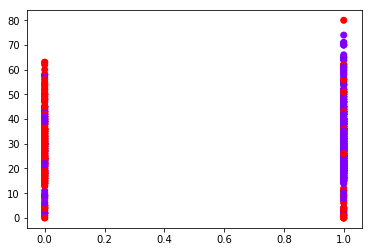

In [9]:
plt.scatter(x_train[:,1], x_train[:,2], c=y_train,cmap='rainbow')

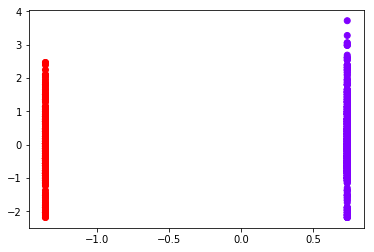

In [10]:
emLabels = GaussianMixture(n_components=2).fit_predict(scaled_train[:,[1,2]])
plt.scatter(scaled_train[:,1], scaled_train[:,2], c=emLabels,cmap='rainbow')

In [11]:
x_train[:,[1,2]].shape

(891, 2)

In [13]:
from minisom import MiniSom

som = MiniSom(2, 1, 2, sigma=1, learning_rate=0.5,
              neighborhood_function='triangle', random_seed=10)


C:\Users\iustin\Anaconda3\lib\site-packages\minisom.py:117: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')


In [14]:
som.train_batch(x_train[:,[1,2]], 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0.00012 it/s - quantization error: 6.5351944924967595


In [15]:
quantization_errors = np.linalg.norm(som.quantization(x_train[:,[1,2]]) - x_train[:,[1,2]], axis=1)
error_treshold = np.percentile(quantization_errors, 
                               100*(1-0.2)+5)
is_survived = quantization_errors > error_treshold

Text(0, 0.5, 'frequency')

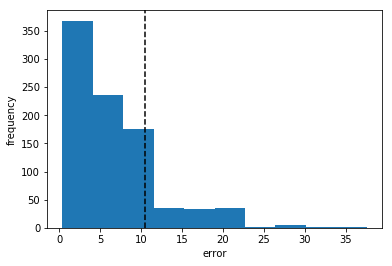

In [16]:
plt.hist(quantization_errors)
plt.axvline(error_treshold, color='k', linestyle='--')
plt.xlabel('error')
plt.ylabel('frequency')

In [17]:
# np.where(np.any(y_train==True))
np.argwhere(y_train==True)
np.argwhere(is_survived==True)

array([[  6],
       [  7],
       [ 10],
       [ 11],
       [ 15],
       [ 16],
       [ 24],
       [ 33],
       [ 43],
       [ 50],
       [ 54],
       [ 58],
       [ 63],
       [ 78],
       [ 94],
       [ 96],
       [116],
       [119],
       [123],
       [124],
       [147],
       [152],
       [164],
       [165],
       [170],
       [171],
       [172],
       [174],
       [182],
       [183],
       [184],
       [190],
       [193],
       [195],
       [198],
       [205],
       [218],
       [232],
       [233],
       [237],
       [240],
       [249],
       [252],
       [261],
       [268],
       [275],
       [278],
       [280],
       [297],
       [305],
       [306],
       [317],
       [326],
       [340],
       [348],
       [366],
       [374],
       [381],
       [386],
       [407],
       [419],
       [438],
       [445],
       [448],
       [456],
       [467],
       [469],
       [479],
       [480],
       [483],
       [487],
      

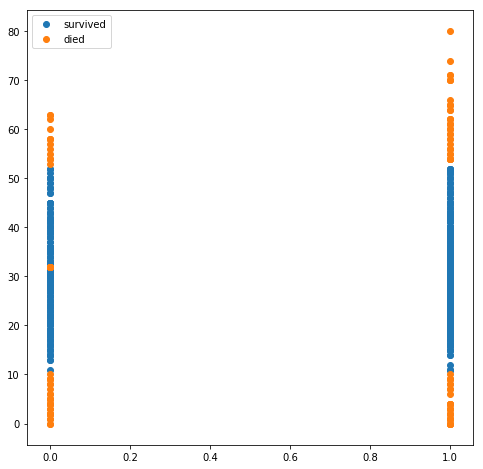

In [18]:
plt.figure(figsize=(8, 8))
plt.scatter(x_train[~is_survived, 1], x_train[~is_survived, 2],
            label='survived')
plt.scatter(x_train[is_survived, 1], x_train[is_survived, 2],
            label='died')
plt.legend()
plt.show()